In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.0 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
import torch
import matplotlib.pyplot as plt
import numpy as np



In [ ]:

# Load IMDb dataset
dataset = load_dataset("imdb")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:

# Load tokenizer for a pre-trained model (for example, BERT)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:

# Tokenize the dataset (using truncation and padding)
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

# Tokenize the datasets
tokenized_datasets = dataset.map(tokenize_function, batched=True)



Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Reduce dataset size for quicker runs (use the full dataset for actual training)
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(5000))  # Reduce size to 5,000 samples
small_test_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))   # Reduce size to 1,000 samples



In [ ]:
# Load pre-trained model for sequence classification
pretrained_model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define a compute_metrics function
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  metric = evaluate.load("accuracy")
  acc = metric.compute(predictions=preds, references=labels)
  return acc


In [ ]:

# Evaluate the pre-trained model before fine-tuning
pretrained_trainer = Trainer(
    model=pretrained_model,
    args=TrainingArguments(
        output_dir="./results",
        per_device_eval_batch_size=8,
        report_to="none",
    ),
    eval_dataset=small_test_dataset,
    compute_metrics=compute_metrics, # Pass the compute_metrics function to the Trainer
)

In [ ]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.9 MB/s eta 0:00:00


In [ ]:
import evaluate

In [ ]:
# Evaluate and get results
pretrained_results = pretrained_trainer.evaluate()
pretrained_accuracy = pretrained_results["eval_accuracy"]
print(pretrained_accuracy)


0.472


In [ ]:
# Training arguments with optimization strategies
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch", # Evaluate at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    fp16=True,
    save_total_limit=1,
    save_strategy = "epoch", # Save checkpoints at the end of each epoch
    load_best_model_at_end=True,
    report_to="none",
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# Load pre-trained model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Define the trainer for fine-tuning
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
# Fine-tune the model
trainer.train()


Epoch,Training Loss,Validation Loss
0,0.502400,0.348254
1,0.276400,0.360764
2,0.189300,0.385504


TrainOutput(global_step=468, training_loss=0.3062778232444046, metrics={'train_runtime': 191.5846, 'train_samples_per_second': 78.294, 'train_steps_per_second': 2.443, 'total_flos': 985087791267840.0, 'train_loss': 0.3062778232444046, 'epoch': 2.9952})

In [ ]:

# Save the fine-tuned model
trainer.save_model("./fine-tuned-bert")


In [ ]:
!pip install datasets evaluate transformers

In [ ]:
# Define a function to compute the accuracy
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  accuracy_metric = evaluate.load("accuracy")
  acc = accuracy_metric.compute(predictions=preds, references=labels) # Use accuracy_metric instead of metric
  return acc

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_test_dataset,
    compute_metrics=compute_metrics, # Add the compute_metrics function
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


In [ ]:
!pip install datasets --upgrade

In [ ]:

# Evaluate the fine-tuned model
fine_tuned_results = trainer.evaluate()
fine_tuned_accuracy = fine_tuned_results["eval_accuracy"]
print(f"Accuracy: {fine_tuned_accuracy}")

Accuracy: 0.855


In [ ]:
# Print evaluation results
print("Pre-trained model accuracy:", pretrained_accuracy)
print("Fine-tuned model accuracy:", fine_tuned_accuracy)


Pre-trained model accuracy: 0.472
Fine-tuned model accuracy: 0.855


In [ ]:
# Visualization
labels = ['Pre-trained Model', 'Fine-tuned Model']
accuracies = [pretrained_accuracy, fine_tuned_accuracy]


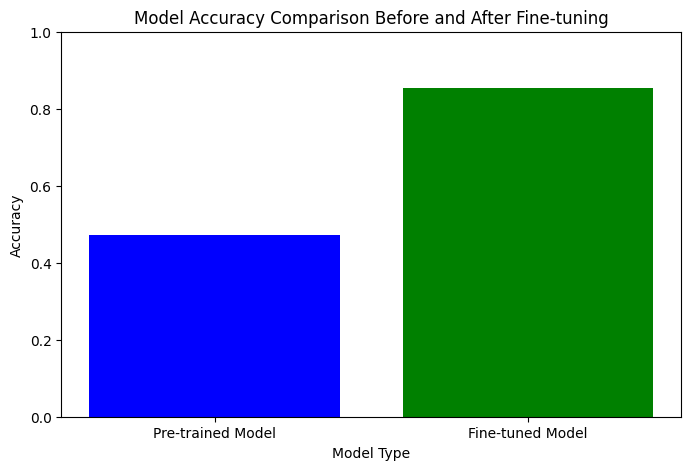

In [ ]:
plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color=['blue', 'green'])
plt.ylim([0, 1])
plt.xlabel('Model Type')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison Before and After Fine-tuning')
plt.show()
